# Phase III: First ML Proof of Concept
## College Admissions Exploration 

- Team
- John Rotondo, Spring Yan, Anne Hu, Evan Li

Each **project group** will submit a single **jupyter notebook** which contains:

1. (3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data
2. (2%) A discussion of the preliminary results:
   - This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
   - It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

In [4]:
from secret import key
import requests
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from collections import defaultdict

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import time

## Fetching & Cleaning Data 

In [5]:
def get_pages_data(key, student_size):
    """ Gets the api response and applies filter on student size, making sure to go through all the pages of data 
    Params:
    - key = api key 
    - student_size = minimum threshold (int)
    Returns:
    A list with the api response stored """
    # Base URL for the College Scorecard API
    base_url = "https://api.data.gov/ed/collegescorecard/v1/schools"
    
    # Parameters for the API call
    params = {
        'api_key': key,
        'per_page': 100,  # Number of records per page (max is usually 100)
        'page': 0,  # Start at the first page
        f'student.size__range': f'{student_size}..',  # Filter for schools with more than 50,000 students
    }
    
    # List to store all school data
    all_schools = []
    
    # Loop through pages until there are no more results
    while True:
        # Increment the page number
        params['page'] += 1
        
        # Make the API request
        response = requests.get(base_url, params=params)
        
        # Check the response status
        if response.status_code != 200:
            print(f"Error: {response.status_code}, {response.text}")
            break
    
        # Get the JSON data
        data = response.json()
        
        # Check if there are results
        if 'results' in data and len(data['results']) > 0:
            # Append the results to the all_schools list
            all_schools.extend(data['results'])
            print(f"Retrieved {len(data['results'])} records from page {params['page']}")
        else:
            # If there are no more results, break the loop
            print(f"No more records found on page {params['page']}. Stopping.")
            break

        # ***** just added this!
        # Optional: delay to avoid API rate limits
        time.sleep(1)
    
    # Print the total number of schools retrieved
    print(f"Total schools retrieved: {len(all_schools)}")
    return all_schools

In [6]:
# load in the data 
data_dct = get_pages_data(key, 10000)

Retrieved 100 records from page 1
Retrieved 100 records from page 2
Retrieved 31 records from page 3
No more records found on page 4. Stopping.
Total schools retrieved: 231


In [7]:
def build_df(data_dct):
    """ Given the json response, gather the data in the colleges_dct and conduct cleaning/filling in missing values for 
        test scores
    """

    # initialize dictionary to store college data
    colleges_dct = defaultdict(list)

    # # gets the average SAT and ACT scores across all schools in the data set for missing values
    # overall_avg_sat = get_all_sat_scores(data_dct)
    # overall_avg_act = get_all_act_scores(data_dct)

    # loop over each "school" in the data_dct
    for i in range(len(data_dct)):
        school_data = data_dct[i]['latest']['school']
        student_data = data_dct[i]['latest']['student']
        admin_data = data_dct[i]['latest']['admissions']

        # append school data
        colleges_dct['name'].append(school_data.get('name'))
        colleges_dct['city'].append(school_data.get('city'))
        colleges_dct['state'].append(school_data.get('state'))
        colleges_dct['ownership'].append(school_data.get('ownership'))

        # append student data
        colleges_dct['size'].append(student_data.get('size'))

        # append admissions data
        colleges_dct['admin_rate'].append(admin_data.get('admission_rate', {}).get('overall'))

        # append test data 
        colleges_dct['avg_sat'].append(admin_data['sat_scores']['average']['overall'])
        colleges_dct['midpoint_act'].append(admin_data['act_scores']['midpoint']['cumulative'])

        # appends test requirement status based on integers given (0-5)
        test_requirement = admin_data.get('test_requirements')
        if test_requirement == 0:
            colleges_dct['test_requirement'].append('Not Required')
        elif test_requirement == 1:
            colleges_dct['test_requirement'].append('Required')
        elif test_requirement == 2:
            colleges_dct['test_requirement'].append('Recommended')
        elif test_requirement == 3:
            colleges_dct['test_requirement'].append('Niether Rec. or Req.')
        elif test_requirement == 4:
            colleges_dct['test_requirement'].append('Not Known')
        else:
            colleges_dct['test_requirement'].append('Considered but not Req.')

        # if a school does not require test scores appends average of data set ACT test scores
        midpoint_act = admin_data.get('act_scores', {}).get('midpoint', {}).get('cumulative')

    return colleges_dct

# Looking into the Fetched Data & NaN Values 

In [55]:
df = pd.DataFrame(build_df(data_dct))
df.head()

,name,city,state,ownership,size,admin_rate,avg_sat,midpoint_act,test_requirement
0,Indian River State College,Fort Pierce,FL,1,11481,NaN,NaN,NaN,Not Required
1,Keiser University-Ft Lauderdale,Fort Lauderdale,FL,2,16649,0.9653,NaN,NaN,Niether Rec. or Req.
2,Miami Dade College,Miami,FL,1,40538,NaN,NaN,NaN,Not Required
3,University of Miami,Coral Gables,FL,2,12215,0.1894,1409.0,32.0,Considered but not Req.
4,University of North Florida,Jacksonville,FL,1,13866,0.7050,1104.0,23.0,Required


In [61]:
def get_admin_rate_for_schools(state) -> int:
    state_df = pd.DataFrame()
    state_df = df[['admin_rate', 'state']].groupby(by='state').mean()
    
    if state is None:
        print("State is None.")
    else:
        return state_df.loc[state, 'admin_rate']

def get_avg_sat_for_schools(state) -> float:
    state_df = pd.DataFrame()
    state_df = df[['avg_sat', 'state']].groupby(by='state').mean()
    
    if state is None:
        print("State is None.")
    else:
        return state_df.loc[state, 'avg_sat']
    
def get_midpoint_act_for_schools(state) -> float:
    state_df = pd.DataFrame()
    state_df = df[['midpoint_act', 'state']].groupby(by='state').mean()
    
    if state is None:
        print("State is None.")
    else:
        return state_df.loc[state, 'midpoint_act']

def fill_missing_values() -> None:
    for index, row in df.iterrows():
        if pd.isna(row['admin_rate']):
            admin = get_admin_rate_for_schools(row['state'])
            df.at[index, 'admin_rate'] = admin
        if pd.isna(row['avg_sat']):
            sat = get_avg_sat_for_schools(row['state'])
            df.at[index, 'avg_sat'] = sat
        if pd.isna(row['midpoint_act']):
            act = get_midpoint_act_for_schools(row['state'])
            df.at[index, 'midpoint_act'] = act

fill_missing_values()
df

,name,city,state,ownership,size,admin_rate,avg_sat,midpoint_act,test_requirement
0,Indian River State College,Fort Pierce,FL,1,11481,0.608580,1215.5,26.0,Not Required
1,Keiser University-Ft Lauderdale,Fort Lauderdale,FL,2,16649,0.965300,1215.5,26.0,Niether Rec. or Req.
2,Miami Dade College,Miami,FL,1,40538,0.608580,1215.5,26.0,Not Required
3,University of Miami,Coral Gables,FL,2,12215,0.189400,1409.0,32.0,Considered but not Req.
4,University of North Florida,Jacksonville,FL,1,13866,0.705000,1104.0,23.0,Required
...,...,...,...,...,...,...,...,...,...
226,Arizona State University Digital Immersion,Scottsdale,AZ,1,46412,0.644800,NaN,NaN,Niether Rec. or Req.
227,University of Phoenix-Arizona,Phoenix,AZ,3,66792,0.644800,NaN,NaN,Not Required
228,Kennesaw State University,Kennesaw,GA,1,38051,0.678500,1133.0,23.0,Required
229,University of the People,Pasadena,CA,2,16253,0.951900,NaN,NaN,Not Required


In [ ]:
# for testing
def get_AL_data():
    state_df = pd.DataFrame()
    df[['admin_rate', 'avg_sat', 'midpoint_act', 'state']].groupby(by='state').mean()
    
    tn_admin = state_df.loc['TN', 'admin_rate']
    fl_admin = state_df.loc['FL', 'admin_rate']
    ga_admin = state_df.loc['GA', 'admin_rate']
    ms_admin = state_df.loc['MS', 'admin_rate']
    
    tn_sat = state_df.loc['TN', 'avg_sat']
    fl_sat = state_df.loc['FL', 'avg_sat']
    ga_sat = state_df.loc['GA', 'avg_sat']
    ms_sat = state_df.loc['MS', 'avg_sat']

    tn_act = state_df.loc['TN', 'midpoint_act']
    fl_act = state_df.loc['FL', 'midpoint_act']
    ga_act = state_df.loc['GA', 'midpoint_act']
    ms_act = state_df.loc['MS', 'midpoint_act']
    
    admin = np.mean((tn_admin, fl_admin, ga_admin, ms_admin))
    sat = np.mean((tn_sat, fl_sat, ga_sat, ms_sat))
    act = np.mean((tn_act, fl_act, ga_act, ms_act))

    return admin, sat, act

def get_AZ_data():
    state_df = pd.DataFrame()
    df[['avg_sat', 'midpoint_act', 'state']].groupby(by='state').mean()
    
    ut_sat = state_df.loc['UT', 'avg_sat']
    nv_sat = state_df.loc['NV', 'avg_sat']
    nm_sat = state_df.loc['NM', 'avg_sat']

    ut_act = state_df.loc['UT', 'midpoint_act']
    nv_act = state_df.loc['NV', 'midpoint_act']
    nm_act = state_df.loc['NM', 'midpoint_act']
    
    sat = np.mean((ut_sat, nv_sat, nm_sat))
    act = np.mean((ut_act, nv_act, nm_act))
    
    return sat, act

def get_CA_data():
    state_df = pd.DataFrame()
    df[['avg_sat', 'midpoint_act', 'state']].groupby(by='state').mean()
    
    or_sat = state_df.loc['OR', 'avg_sat']
    nv_sat = state_df.loc['NV', 'avg_sat']

    or_act = state_df.loc['OR', 'midpoint_act']
    nv_act = state_df.loc['NV', 'midpoint_act']
    
    sat = np.mean((or_sat, nv_sat))
    act = np.mean((or_act, nv_act))
    
    return sat, act

def temp():
    if row['state'] == 'AL':
            admin, sat, act = get_AL_data()
            df.at[index, 'admin_rate'] = admin
            df.at[index, 'avg_sat'] = sat
            df.at[index, 'midpoint_act'] = act
        elif row['state'] == 'AZ':
            sat, act = get_AZ_data()
            df.at[index, 'avg_sat'] = sat
            df.at[index, 'midpoint_act'] = act
        elif row['state'] == 'CA':
            sat, act = get_CA_data()
            df.at[index, 'avg_sat'] = sat
            df.at[index, 'midpoint_act'] = act

In [54]:
def get_PR_midpoint_act() -> int, float, float:
    state_df = pd.DataFrame()
    df[['admin_rate', 'avg_sat', 'midpoint_act', 'state']].groupby(by='state').mean()
    # finish this



state_df

25.2202380952381


,midpoint_act
state,
AL,NaN
AZ,NaN
CA,NaN
FL,26.000000
GA,24.714286
HI,24.000000
IA,25.500000
ID,23.000000
IL,28.250000


In [6]:
# --- analyze NaN value count 
nan_count = df.isna().sum()
nan_count

name                  0
city                  0
state                 0
ownership             0
size                  0
admin_rate           67
avg_sat              94
midpoint_act        107
test_requirement      0
dtype: int64

In [7]:
# --- if drop the nan values
df.shape

(231, 9)

In [8]:
# --- find unqiue test requirements
set(df['test_requirement'])

# -- now check if each category has a correpsonding test 
df[['admin_rate', 'avg_sat', 'midpoint_act', 'test_requirement']].groupby(by='test_requirement').mean()

,admin_rate,avg_sat,midpoint_act
test_requirement,,,
Considered but not Req.,0.726865,1222.330579,26.380952
Niether Rec. or Req.,0.751909,NaN,22.666667
Not Required,NaN,NaN,NaN
Required,0.674512,1202.312500,25.250000


In [9]:
df[df['test_requirement'] == "Not Required"]

,name,city,state,ownership,size,admin_rate,avg_sat,midpoint_act,test_requirement
0,Indian River State College,Fort Pierce,FL,1,11481,NaN,NaN,NaN,Not Required
2,Miami Dade College,Miami,FL,1,40538,NaN,NaN,NaN,Not Required
5,Palm Beach State College,Lake Worth,FL,1,20378,NaN,NaN,NaN,Not Required
6,St Petersburg College,St. Petersburg,FL,1,18984,NaN,NaN,NaN,Not Required
7,Santa Fe College,Gainesville,FL,1,11038,NaN,NaN,NaN,Not Required
...,...,...,...,...,...,...,...,...,...
221,American Public University System,Charles Town,WV,3,37569,NaN,NaN,NaN,Not Required
222,Columbia Southern University,Orange Beach,AL,3,11208,NaN,NaN,NaN,Not Required
227,University of Phoenix-Arizona,Phoenix,AZ,3,66792,NaN,NaN,NaN,Not Required
229,University of the People,Pasadena,CA,2,16253,NaN,NaN,NaN,Not Required


In [10]:
len(set(df['state']))

df[['admin_rate', 'avg_sat', 'midpoint_act', 'state']].groupby(by='state').mean()

,admin_rate,avg_sat,midpoint_act
state,,,
AL,NaN,NaN,NaN
AZ,0.644800,NaN,NaN
CA,0.951900,NaN,NaN
FL,0.608580,1215.500000,26.000000
GA,0.697033,1168.000000,24.714286
HI,0.727700,1113.000000,24.000000
IA,0.881100,1209.500000,25.500000
ID,0.897450,1107.000000,23.000000
IL,0.704600,1232.833333,28.250000


In [11]:
ca_df = df[df['state'] == 'CA']
# print(list(ca_df['name']))

# ---- confirmed the size is over 10000, but doesn't show up when put on the 10000 filter? 
ca_df[ca_df['name'] == 'University of California-San Diego']

,name,city,state,ownership,size,admin_rate,avg_sat,midpoint_act,test_requirement


In [12]:
ma_df = df[df['state'] == 'MA']
ma_df

,name,city,state,ownership,size,admin_rate,avg_sat,midpoint_act,test_requirement
51,Boston University,Boston,MA,2,17668,0.1437,1454.0,33.0,Considered but not Req.
52,University of Massachusetts-Lowell,Lowell,MA,1,11985,0.8595,1255.0,29.0,Considered but not Req.
53,University of Massachusetts-Amherst,Amherst,MA,1,24111,0.6352,1376.0,31.0,Considered but not Req.
54,University of Massachusetts-Boston,Boston,MA,1,11749,0.8076,1198.0,27.0,Considered but not Req.
55,Northeastern University,Boston,MA,2,16172,0.0680,1505.0,34.0,Considered but not Req.


In [13]:
df[df['name'] == 'Northeastern University']

,name,city,state,ownership,size,admin_rate,avg_sat,midpoint_act,test_requirement
55,Northeastern University,Boston,MA,2,16172,0.068,1505.0,34.0,Considered but not Req.


In [14]:
df[df['name'] == 'Harvard University']

,name,city,state,ownership,size,admin_rate,avg_sat,midpoint_act,test_requirement


In [15]:
# ---- where is the University of Alabama? 
al_df = df[df['state'] == 'AL']
al_df
# al_df[al_df['name'] == '']

,name,city,state,ownership,size,admin_rate,avg_sat,midpoint_act,test_requirement
222,Columbia Southern University,Orange Beach,AL,3,11208,NaN,NaN,NaN,Not Required


In [16]:
drop_df = df.dropna()
# len(set(df['state']))
len(set(drop_df['state']))

36

In [17]:
# --- potential to use ownership as a more granular avg. 

# ----- dropped private, for-profit universities (much smaller amount & have a lot less test data)
df[['admin_rate', 'avg_sat', 'midpoint_act', 'ownership']].groupby(by='ownership').mean()

,admin_rate,avg_sat,midpoint_act
ownership,,,
1,0.747561,1201.352941,25.550459
2,0.568595,1358.411765,30.466667
3,0.722067,1085.000000,NaN


# ML Model 

In [18]:
# ---- fetch data & clean data here!

## Regression Functions

In [19]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

In [20]:
def line_of_best_fit(X, y):
    """ Args: 
            X (array): either 1d or 2d with the predictor values 
            y (array): 1d and corresponding response values to 'X'
        Returns: 
            m (vector): vector with the slope and intercept term of the line of best fit"""
    # first call the add_bias_column for line of best fit calculation 
    Xnew = add_bias_column(X)
    
    # get the inverse of X transpose 
    XtXinv = np.linalg.inv(np.matmul(Xnew.T, Xnew))
    
    # get the vector with the slope and intercept term
    m = np.matmul(XtXinv, np.matmul(Xnew.T, y))

    return m

In [21]:
def linreg_predict(Xnew, ynew, m):
    """ Args: 
            Xnew (array): 1d or 2d with all predictor values, not including bias term
            ynew (array): 1d with all corresponding response values to 'Xnew'
            m (array): 1d array that contains the coefficents form the line_of_best_fit function
        Returns:
            result_dict (dct): A dct with 4 key-value pairs - ypreds, resids, mse, and r2"""
    
    # add bias column 
    Xnew = add_bias_column(Xnew)

    # fetch all the calculations
    ypreds = np.matmul(Xnew, m)

    resids = ynew - ypreds
    
    mse = np.mean(resids ** 2)

    # use of sklearn built-in r2_score function 
    r2 = r2_score(ynew, ypreds)

    # set up key-value pairs in the resulting dictionary 
    result_dict = {'ypreds': ypreds,
                  'resids': resids,
                  'mse': mse,
                  'r2': r2}

    return result_dict

## Simple Linear Regression
Average SAT to predict Admission Rate 

In [22]:
# CROSS-FOLD VALIDATION
# ------- note: using dropped df to confirm model works, need to switch the out with cleaned_df
X_train, X_test, y_train, y_test = train_test_split(drop_df['avg_sat'], drop_df['admin_rate'], test_size=0.30, random_state=42)

# now fit model using line_of_best_fit function
m_train = line_of_best_fit(X_train, y_train)

# use test data to evaulate the model using the linreg_predict function, get "m" param from fitting the model above 
results = linreg_predict(X_test, y_test, m_train)

print(f"MSE: {results['mse']}, R^2: {results['r2']}")

MSE: 0.026609726609841414, R^2: 0.599486899830726


In [34]:
# fit the regression model to the full data set 
m_full = line_of_best_fit(drop_df["avg_sat"], drop_df["admin_rate"])
slope = m_full[1]
intercept = m_full[0]


X = drop_df["avg_sat"]

y_pred = slope * X + intercept

## Multiple Linear Regression
Average SAT & Midpoint ACT to predict Admission Rate 

In [40]:
# standarize the features! 

# define
x_feat_list = ['avg_sat', 'midpoint_act']
drop_df_num = drop_df[x_feat_list]

# scale the features using standardization
drop_df_scaled = pd.DataFrame()

for feat in drop_df_num.columns:
    drop_df_scaled[f'{feat}_scaled'] = ((drop_df_num[feat] - drop_df_num[feat].mean()) / drop_df_num[feat].std())

# convert dataframe to numpy array 
X_scaled = np.array(drop_df_scaled)
X_scaled[0]

array([1.39665131, 1.58851786])

In [44]:
# CROSS-FOLD VALIDATION
X_train, X_test, y_train, y_test = train_test_split(X_scaled, drop_df['admin_rate'], test_size=0.30, random_state=42)

# now fit model using line_of_best_fit function
m_multi = line_of_best_fit(X_train, y_train)

# use test data to evaulate the model using the linreg_predict function, get "m" param from fitting the model above 
multi_results = linreg_predict(X_test, y_test, m_multi)

print(f"MSE: {multi_results['mse']}, R^2: {multi_results['r2']}")

MSE: 0.02660113021767163, R^2: 0.5996162873937277


Very similar results to the simple regression model with just average SAT!

# Dicussion of Results

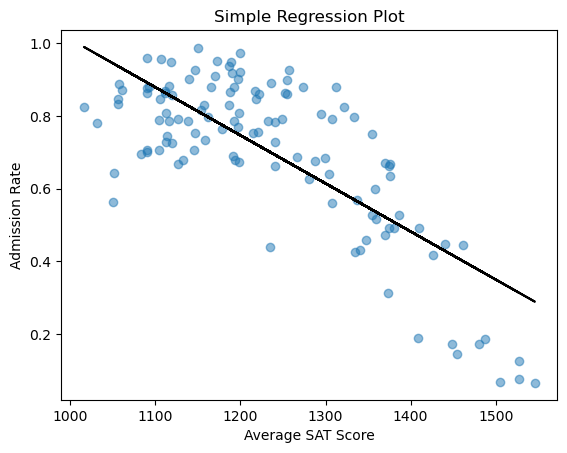

In [35]:
# --- INTIAL PLOT to see fit of the simple regression 
plt.scatter(X, drop_df["admin_rate"], label='data', alpha=0.5)

plt.plot(X, y_pred, color='black',label='linear fit')

plt.xlabel("Average SAT Score")
plt.ylabel("Admission Rate")
plt.title("Simple Regression Plot")
plt.show()

In [ ]:
# plot assumptions for simple & multiple regression model | compare them! 